# Kaggle Competition: Allstate Claims Severity
https://www.kaggle.com/c/allstate-claims-severity

This is my first real go with a kaggle competition, along with using tensorflow and scikit-learn. 
Let's see what we can do here. 

## Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math as m
import os
import hashlib
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:.5f}'.format

filepath = os.path.join(os.getcwd(),"Data")
labeled_dataset = pd.read_csv(os.path.join(filepath,"train.csv"), index_col = None)
"Dataset Size (Rows, Columns): " + str(labeled_dataset.shape)

'Dataset Size (Rows, Columns): (188318, 132)'

### Data exploration and cleanup
After importing the data and our necesary packages, let's take a look at the training set provided to us.

In [2]:
labeled_dataset.head(n=7) #mix of categorical and continuous variables

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.71837,0.33506,0.30260,0.67135,0.83510,0.56974,0.59465,0.82249,0.71484,2213.18000
1,2,A,B,A,A,A,A,A,A,B,...,0.43892,0.43659,0.60087,0.35127,0.43919,0.33831,0.36631,0.61143,0.30450,1283.60000
2,5,A,B,A,A,B,A,A,A,B,...,0.28965,0.31554,0.27320,0.26076,0.32446,0.38140,0.37342,0.19571,0.77443,3005.09000
3,10,B,B,A,B,A,A,A,A,B,...,0.44094,0.39113,0.31796,0.32128,0.44467,0.32792,0.32157,0.60508,0.60264,939.85000
4,11,A,B,A,B,A,A,A,A,B,...,0.17819,0.24741,0.24564,0.22089,0.21230,0.20469,0.20221,0.24601,0.43261,2763.85000
5,13,A,B,A,A,A,A,A,A,B,...,0.36446,0.40116,0.26847,0.46226,0.50556,0.36679,0.35925,0.34525,0.72679,5142.87000
6,14,A,A,A,A,B,A,A,A,A,...,0.38151,0.36377,0.24564,0.40455,0.47225,0.33483,0.35225,0.34224,0.38293,1132.22000


There is a mix of categorical variables and continuous variables. 

The variable names have been (presumbably) scrubbed of identifying information for privacy reasons, and thus domain knowledge of the insurance pricing process will not be of much help in this excercise. Category names have been converted into letters, and it appears that the continuous variables, except for the loss variable, have been normalized to fit between 0 and 1.

The "loss" variable, our target variable, is continuous. This will be a regression problem.

In [3]:
labeled_dataset.isnull().sum().sum() #no missing data!

0

Luckily, there doesn't seem to be any variables with missing values, so no imputation or adjustments for missing data need to be made. Looks like the ETL pipeline is already in place and functioning well, so there's no need to data munging/ data janitor work.

Let's take a look at the continuous variables.

In [4]:
cont_dataset = labeled_dataset.iloc[:,-15:].copy()
cont_dataset.head(n=7)

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,0.72630,0.24592,0.18758,0.78964,0.31006,0.71837,0.33506,0.30260,0.67135,0.83510,0.56974,0.59465,0.82249,0.71484,2213.18000
1,0.33051,0.73707,0.59268,0.61413,0.88583,0.43892,0.43659,0.60087,0.35127,0.43919,0.33831,0.36631,0.61143,0.30450,1283.60000
2,0.26184,0.35832,0.48420,0.23692,0.39707,0.28965,0.31554,0.27320,0.26076,0.32446,0.38140,0.37342,0.19571,0.77443,3005.09000
3,0.32159,0.55578,0.52799,0.37382,0.42227,0.44094,0.39113,0.31796,0.32128,0.44467,0.32792,0.32157,0.60508,0.60264,939.85000
4,0.27320,0.15999,0.52799,0.47320,0.70427,0.17819,0.24741,0.24564,0.22089,0.21230,0.20469,0.20221,0.24601,0.43261,2763.85000
5,0.54667,0.68176,0.63422,0.37382,0.30268,0.36446,0.40116,0.26847,0.46226,0.50556,0.36679,0.35925,0.34525,0.72679,5142.87000
6,0.47145,0.73707,0.61366,0.18914,0.29540,0.38151,0.36377,0.24564,0.40455,0.47225,0.33483,0.35225,0.34224,0.38293,1132.22000


In [5]:
cont_dataset.describe() #excluding loss, all the continuous variables are between 0 and 1-ish.

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000
mean,0.49386,0.50719,0.49892,0.49181,0.48743,0.49094,0.48497,0.48644,0.48551,0.49807,0.49351,0.49315,0.49314,0.49572,3037.33769
std,0.18764,0.20720,0.20210,0.21129,0.20903,0.20527,0.17845,0.19937,0.18166,0.18588,0.20974,0.20943,0.21278,0.22249,2904.08619
min,0.00002,0.00115,0.00263,0.17692,0.28114,0.01268,0.06950,0.23688,0.00008,0.00000,0.03532,0.03623,0.00023,0.17972,0.67000
25%,0.34609,0.35832,0.33696,0.32735,0.28114,0.33611,0.35018,0.31280,0.35897,0.36458,0.31096,0.31166,0.31576,0.29461,1204.46000
50%,0.47578,0.55578,0.52799,0.45289,0.42227,0.44094,0.43829,0.44106,0.44145,0.46119,0.45720,0.46229,0.36355,0.40740,2115.57000
75%,0.62391,0.68176,0.63422,0.65207,0.64331,0.65502,0.59104,0.62358,0.56682,0.61459,0.67892,0.67576,0.68997,0.72462,3864.04500
max,0.98498,0.86265,0.94425,0.95430,0.98367,0.99716,1.00000,0.98020,0.99540,0.99498,0.99874,0.99848,0.98849,0.84485,121012.25000


Initial suspicions that the continuous variables (except for loss) were normalized between 0 and 1 are true. 

The loss variable seems to be skewed to the right. Let's plot the histogram of the loss variable to gain idea of the distribution shape.

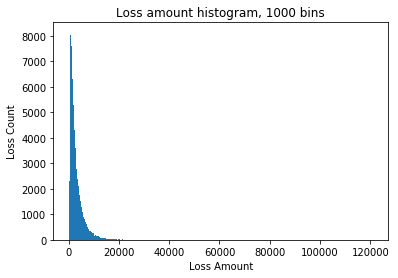

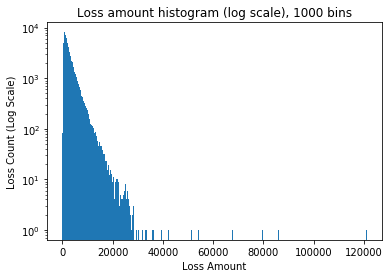

In [6]:
plt.hist(cont_dataset.loss, 1000);
plt.title("Loss amount histogram, 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count");
plt.show();

plt.hist(cont_dataset.loss, 1000);
plt.title("Loss amount histogram (log scale), 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count (Log Scale)");
plt.yscale("log");
plt.show(); #loss amounts are heavily skewed to the right

Loss is heavily skewed to the right. Plotting the histogram with a logarithmic scale shows that most losses are below 20,000.

Most machine learning algorithms perform best on inputs and outputs that have been preprocessed to some degree. 
While the continuous variables have been normalized(assign minimum value to 0, maximum to 1, and linearly interpolate all values inbetween), the loss variable has not.

We can transform the loss variable by first taking the natural logarithm, and then standardizing it (convert the logarithmic losses into z-scores).

The continuous variables have been normalized-ish. It appears that they don't exact have a range between 0 and 1, but slightly smaller than that. Since we're standardizing the loss, for sake of consistency, we should also standardize the continuous variables. 

In [7]:
cont_dataset['logloss'] = np.log(cont_dataset['loss'])

cont_scaler = StandardScaler()
loss_scaler = StandardScaler()

cont_dataset_var = cont_dataset.iloc[:,:15].copy()
cont_dataset_var = pd.DataFrame(cont_scaler.fit_transform(cont_dataset_var),columns=cont_dataset_var.columns)
cont_dataset_logloss = cont_dataset.iloc[:,-1:].copy()
cont_dataset_logloss = pd.DataFrame(loss_scaler.fit_transform(cont_dataset_logloss),columns=cont_dataset_logloss.columns)

cont_dataset_scaled = pd.concat([cont_dataset_var, cont_dataset_logloss], axis = 1)
cont_dataset_scaled.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,logloss
count,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000,188318.00000
mean,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
min,-2.63188,-2.44226,-2.45559,-1.49032,-0.98688,-2.32989,-2.32820,-1.25173,-2.67217,-2.67956,-2.18460,-2.18176,-2.31656,-1.42029,-1.04566,-9.95946
25%,-0.78753,-0.71848,-0.80135,-0.77835,-0.98688,-0.75431,-0.75537,-0.87093,-0.69656,-0.71814,-0.87038,-0.86660,-0.83364,-0.90390,-0.63114,-0.72855
50%,-0.09634,0.23452,0.14385,-0.18423,-0.31173,-0.24358,-0.26162,-0.22760,-0.24252,-0.19839,-0.17311,-0.14738,-0.60905,-0.39694,-0.31740,-0.03472
75%,0.69309,0.84253,0.66948,0.75848,0.74578,0.79931,0.59442,0.68788,0.44762,0.62689,0.88403,0.87195,0.92508,1.02885,0.28467,0.70726
max,2.61732,1.71556,2.20348,2.18885,2.37409,2.46608,2.88613,2.47662,2.80686,2.67336,2.40889,2.41294,2.32806,1.56922,40.62387,4.94956


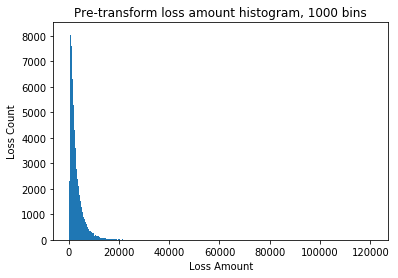

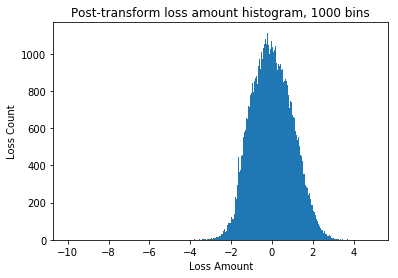

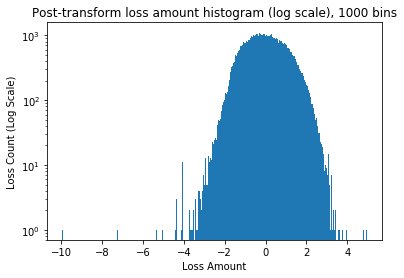

In [8]:
plt.hist(cont_dataset.loss, 1000);
plt.title("Pre-transform loss amount histogram, 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count");
plt.show();

plt.hist(cont_dataset_scaled.logloss, 1000);
plt.title("Post-transform loss amount histogram, 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count");
plt.show();

plt.hist(cont_dataset_scaled.logloss, 1000);
plt.title("Post-transform loss amount histogram (log scale), 1000 bins");
plt.xlabel("Loss Amount");
plt.ylabel("Loss Count (Log Scale)");
plt.yscale("log");
plt.show(); #loss amounts roughly resemble a 0-centered normal distribution after transformation

After taking the natural logarithm of the losses and standardizing them, the distribution of logarithmic losses now resemble a normal distribution (bell curve), and will be much easier for machine learning algorithms to handle.

Let's take a look at the categorical variables.

In [9]:
cat_dataset = labeled_dataset.iloc[:,1:-15].copy()
cat_dataset.head(n=7) #categorical variables

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK
5,A,B,A,A,A,A,A,A,B,A,...,F,B,BI,CS,A,AS,AE,A,K,DJ
6,A,A,A,A,B,A,A,A,A,A,...,F,B,BI,DK,A,J,AF,A,K,DJ


There are far more categorical variables than continuous ones (116 vs. 14).

The first couple of categorical variables seem to only have 2 unique categories (A vs. B), whereas the last few seem to have a lot more categories (A, B, C... , AZ, AB, AC...)

Let's examine the cardinality(number of unique categories) of each categorical variable, and see how many are binary (A vs. B only)

In [10]:
pd.DataFrame(cat_dataset.nunique(),columns=['Unique Categories']).head(n=7)
pd.DataFrame(cat_dataset.nunique(),columns=['Unique Categories']).tail(n=7)
"There are " + str(list(cat_dataset.nunique()).count(2)) + " binary variables."

,Unique Categories
cat1,2
cat2,2
cat3,2
cat4,2
cat5,2
cat6,2
cat7,2


,Unique Categories
cat110,131
cat111,16
cat112,51
cat113,61
cat114,19
cat115,23
cat116,326


'There are 72 binary variables.'

Out of the 116 categorical variables, there are 72 binary variables. 

One concern is that out of the remaining 42 non-binary variables, how many of the extra categories are poorly represented in the data? For example, the cat116 variable has 326 unique categories. 

Even assuming that all 326 categories were all evenly represented in the 188318 rows provided, that would mean each category would only have roughly 578 instances. Most likely, some categories are very prominently featured, and many categories would only have a handful of instances.

Let's confirm by examining the row counts for the least and second to least common categories for each of the 114 categorical variables. 

In [11]:
min_freq=[] #least common category occurences
min2_freq=[] #second least common category occurences
avg_freq=[] #average category occurence number
freq_std=[] #standard deviation in category occurence number
for column in cat_dataset.columns:
    min_freq.append(int(cat_dataset[column].value_counts().min()))
    min2_freq.append(int(cat_dataset[column].value_counts().nsmallest().iloc[1]))
    avg_freq.append(int(cat_dataset[column].value_counts().mean()))
    freq_std.append(int(cat_dataset[column].value_counts().std()))
extra_desc = pd.DataFrame([min_freq,min2_freq,avg_freq,freq_std],columns=cat_dataset.columns)
extra_desc = extra_desc.rename({0:"minfreq",1:"min2freq",2:"avgfreq",3:"freqstd"})
cat_dataset.describe().append(extra_desc)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,...,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,...,20,11,84,131,16,51,61,19,23,326
top,A,A,A,A,A,A,A,A,A,A,...,F,B,BI,CL,A,E,BM,A,K,HK
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,...,47310,65512,152918,25305,128395,25148,26191,131693,43866,21061
minfreq,46768,81597,10325,59923,64581,56625,4574,11044,75196,28105,...,2,213,1,1,2,30,1,1,1,1
min2freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,...,2,520,1,1,3,144,1,1,2,1
avgfreq,94159,94159,94159,94159,94159,94159,94159,94159,94159,94159,...,9415,17119,2241,1437,11769,3692,3087,9911,8187,577
freqstd,67020,17765,118559,48417,41829,53081,126692,117542,26817,93414,...,13310,20051,16814,4649,32247,5361,4986,29975,12032,2008


As suspected, many of the non-binary categorical variables have categories that appear only once in the entire dataset. If there are instances of the single appearance categories in the testing dataset that were not in the training dataset, the models would not be able to handle prediction for those instances, as the models will not have been trained to deal with the single instance categories. 

Let's clean the dataset by dropping columns whose least common category appears less than 0.25% of the time in the training dataset, or roughly 471 times. 

In [12]:
# discard high cardinality variables
threshold = 0.0025
for column in cat_dataset.columns:
    if cat_dataset[column].value_counts().min() < threshold*cat_dataset.shape[0]:
        cat_dataset = cat_dataset.drop([column], axis=1)
        
min_freq=[]
min2_freq=[]
avg_freq=[]
freq_std=[]
for column in cat_dataset.columns:
    min_freq.append(int(cat_dataset[column].value_counts().min()))
    min2_freq.append(int(cat_dataset[column].value_counts().nsmallest().iloc[1]))
    avg_freq.append(int(cat_dataset[column].value_counts().mean()))
    freq_std.append(int(cat_dataset[column].value_counts().std()))
    
extra_desc = pd.DataFrame([min_freq,min2_freq,avg_freq,freq_std],columns=cat_dataset.columns)
extra_desc = extra_desc.rename({0:"minfreq",1:"min2freq",2:"avgfreq",3:"freqstd"})
cat_dataset.describe().append(extra_desc)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat76,cat79,cat80,cat81,cat82,cat83,cat85,cat86,cat87,cat98
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,...,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,...,3,4,4,4,4,4,4,4,4,5
top,A,A,A,A,A,A,A,A,A,A,...,A,B,D,D,B,B,B,B,B,A
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,...,181347,152929,137505,154385,147536,141534,186005,103852,166992,105492
minfreq,46768,81597,10325,59923,64581,56625,4574,11044,75196,28105,...,788,1668,783,788,2655,4958,514,1589,788,542
min2freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,...,6183,7064,3492,9013,18805,15788,788,10290,8819,10242
avgfreq,94159,94159,94159,94159,94159,94159,94159,94159,94159,94159,...,62772,47079,47079,47079,47079,47079,47079,47079,47079,37663
freqstd,67020,17765,118559,48417,41829,53081,126692,117542,26817,93414,...,102723,71378,63823,72187,67416,63555,92617,49317,80075,42304


Out of the 116 categorical variables, only 65 of them have their least common category appear more than 0.25% of the time in the training dataset.

Let's convert the categorical variables into dummy variables. 

This takes a categorical variable and converts it into a more usuable form for machine learning algorithms. 

For example, if a variable has three unique categories: A, B ,and C, converting it into a dummy variable turns it into two variables, variable_B and variable_C. If an instance is part of category B, then variable_B is valued at 1 and variable_C is valued at 0. If an instance is part of category A, then variable_B is valued at 0 and variable_C is valued at 0. Variable_A is not explicitly stated in the dummy variable conversion, but a 0 for all categories implies category A. 

In [13]:
cat_dataset = pd.get_dummies(data=cat_dataset,drop_first=True) #convert categorial variables to one-hot encoding
cat_dataset.head(n=7)

,cat1_B,cat2_B,cat3_B,cat4_B,cat5_B,cat6_B,cat7_B,cat8_B,cat9_B,cat10_B,...,cat86_B,cat86_C,cat86_D,cat87_B,cat87_C,cat87_D,cat98_B,cat98_C,cat98_D,cat98_E
0,0,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,1,1,...,0,0,1,1,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,1,1,...,1,0,0,1,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


Join the dummy variables with the continuous variables before we move on. 

In [14]:
cleaned_dataset = pd.concat([labeled_dataset.id,cat_dataset,cont_dataset_scaled], axis=1)
cleaned_dataset.head(n=7)

,id,cat1_B,cat2_B,cat3_B,cat4_B,cat5_B,cat6_B,cat7_B,cat8_B,cat9_B,...,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss,logloss
0,1,0,1,0,1,0,0,0,0,1,...,-0.84007,-0.92209,1.02303,1.81322,0.36348,0.48464,1.54789,0.98489,-0.28379,0.02084
1,2,0,1,0,0,0,0,0,0,1,...,-0.27114,0.57397,-0.73894,-0.31675,-0.73997,-0.60567,0.55595,-0.85947,-0.60389,-0.65016
2,5,0,1,0,0,1,0,0,0,1,...,-0.94943,-1.06956,-1.23718,-0.93399,-0.53454,-0.57169,-1.39784,1.25269,-0.01110,0.39760
3,10,1,1,0,1,0,0,0,0,1,...,-0.52587,-0.84505,-0.90403,-0.28727,-0.78955,-0.81929,0.52609,0.48059,-0.72226,-1.03410
4,11,0,1,0,1,0,0,0,0,1,...,-1.33126,-1.20779,-1.45666,-1.53740,-1.37708,-1.38921,-1.16144,-0.28366,-0.09417,0.29452
5,13,0,1,0,0,0,0,0,0,1,...,-0.46965,-1.09328,-0.12797,0.04032,-0.60420,-0.63937,-0.69505,1.03860,0.72503,1.05941
6,14,0,0,0,0,1,0,0,0,0,...,-0.67920,-1.20779,-0.44565,-0.13889,-0.75658,-0.67279,-0.70919,-0.50693,-0.65601,-0.80473


Next we'll split the training dataset into 3 pieces: training, validation, and testing.

We'll train our models on the training dataset, fine-tune the hyperparameters using the validation dataset, and check for overfitting on the testing dataset.

We'll split the dataset bashed on the hash of the id variable. 

The proportions will be 60% training, 20% validation and 20% testing. 

In [15]:
def test_split(id, seed, test_proportion):
    if type(test_proportion) not in [float, int] or test_proportion > 1 or test_proportion < 0:
        raise ValueError("Test proportion must be a real number between 0 and 1")
    test = str(id) + str(seed)
    test_digest = hashlib.md5(test.encode("ascii")).hexdigest()
    test_hex = int(test_digest[-6:], 16) #last 6 digits only
    split = test_hex/0xFFFFFF
    if split > test_proportion:
        return 0
    else:
        return 1

cleaned_dataset['split'] = cleaned_dataset['id'].map(lambda x: test_split(id = x, seed = 'testing set', test_proportion = 0.20))
cleaned_dataset['split'].sum()/cleaned_dataset.shape[0] #verify split percentage is correct

test = cleaned_dataset.loc[(cleaned_dataset.split == 1)]
train_valid = cleaned_dataset.loc[(cleaned_dataset.split == 0)].copy()
train_valid['split'] = train_valid['id'].map(lambda x: test_split(id = x, seed = 'validation set', test_proportion = 0.25))
train_valid['split'].sum()/train_valid.shape[0] #verify split percentage is correct
train = train_valid.loc[(train_valid.split == 0)]
valid = train_valid.loc[(train_valid.split == 1)]


train_x = train.iloc[:,1:-3].copy()
train_y = train.iloc[:,-2:-1].copy()
train_y_actual = np.exp(loss_scaler.inverse_transform(train_y))
valid_x = valid.iloc[:,1:-3].copy()
valid_y = valid.iloc[:,-2:-1].copy()
valid_y_actual = np.exp(loss_scaler.inverse_transform(valid_y))
test_x = test.iloc[:,1:-3].copy()
test_y = test.iloc[:,-2:-1].copy()
test_y_actual = np.exp(loss_scaler.inverse_transform(test_y))

0.1991631177051583

0.24872026098718936

We've verified that the proportions are correct (0.2 of the original training set has been designated as the testing set, and 0.25 of the remaining 0.8, or 0.2 of the original has been designated as the validation set)

The data has been processed to our liking, and is now ready to be used by machine learning algorithms. 

Let's train a neural network on the data. Initial the neural network hyperparamters, and let's build the network in TensorFlow.

We'll train the neural network using stochastic gradient descent (batch size of 1), with an Adam(adaptive moment estimation) optimizer. Use L2 regularization, with a regularization parameter of 0.001 to avoid overfitting. Set the learning rate to 0.0001.

We'll use 4 hidden leaky ReLU layers, with a single output node outputting the standardized logarithmic loss. 

We'll calculate the root mean squared error of our neural network's predictions on the validation set at every training epoch, and save the model parameters if the loss is the lowest seen so far. 

In [16]:
valid_min = 1300 #arbitrary initial cutoff
reg_param = 0.001
learning_rate = 0.0001
num_epochs = 5000
seed = 42
# np.random.seed(15435)

tf.reset_default_graph()

tf_x = tf.placeholder(tf.float32, [None, train_x.shape[1]])
tf_y = tf.placeholder(tf.float32, [None, train_y.shape[1]])

layer1 = tf.layers.dense(tf_x, 100, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
layer2 = tf.layers.dense(layer1, 80, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
layer3 = tf.layers.dense(layer2, 70, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
layer4 = tf.layers.dense(layer3, 40, tf.nn.leaky_relu, kernel_regularizer= tf.contrib.layers.l2_regularizer(reg_param))
output = tf.layers.dense(layer4, 1, kernel_regularizer=tf.contrib.layers.l2_regularizer(reg_param))

loss = tf.losses.mean_squared_error(tf_y, output) + tf.losses.get_regularization_loss()
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss)
loss_history_valid = []
loss_history_train = []

with tf.Session() as sess:
    tf.set_random_seed(seed)
#     sess.run(tf.global_variables_initializer())    
    saver = tf.train.Saver()
    saver.restore(sess, './params')
    for epoch in range(num_epochs):
        raw_output = sess.run(output, {tf_x: valid_x})
        valid_pred_nn = np.exp(loss_scaler.inverse_transform(raw_output))
        unscaled_loss = mean_absolute_error(valid_y_actual, valid_pred_nn)
        loss_history_valid.append(unscaled_loss)
        
        raw_output = sess.run(output, {tf_x: train_x})
        train_pred_nn = np.exp(loss_scaler.inverse_transform(raw_output))
        unscaled_loss = mean_absolute_error(train_y_actual, train_pred_nn)
        loss_history_train.append(unscaled_loss) #calculating the training loss slows down training
        
#         if unscaled_loss < valid_min:
#             saver.save(sess, './params', write_meta_graph=False)
#             valid_min = unscaled_loss
#             print(valid_min)
        random_rows = np.random.choice(train.shape[0], 1, replace=False)    
        sess.run(train_op, {tf_x: train_x.iloc[random_rows, :], tf_y: train_y.iloc[random_rows, :]})
#         sess.run(train_op, {tf_x: train_x, tf_y: train_y}) #feeds the entire dataset into the model for training

    raw_output = sess.run(output, {tf_x: valid_x})
    valid_pred_nn_unscaled = np.exp(loss_scaler.inverse_transform(raw_output))
    train_pred_nn = sess.run(output, {tf_x: train_x})
    valid_pred_nn = sess.run(output, {tf_x: valid_x})
    test_pred_nn = sess.run(output, {tf_x: test_x})

INFO:tensorflow:Restoring parameters from ./params


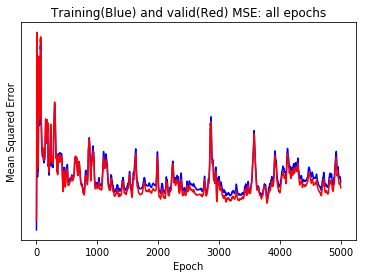

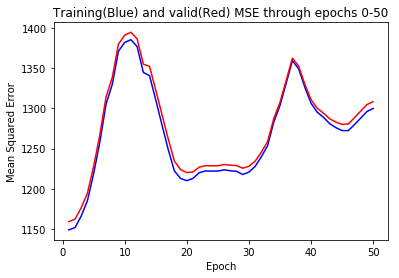

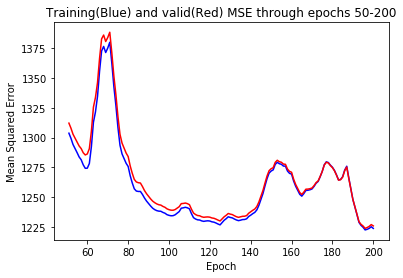

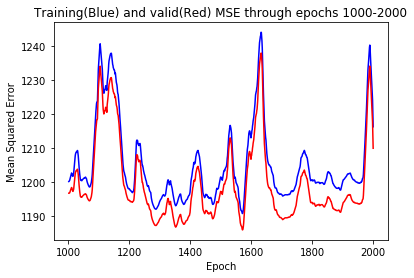

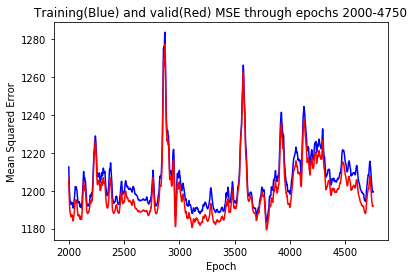

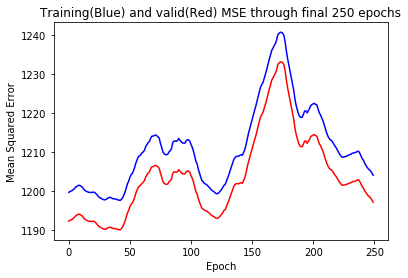

In [17]:
plt.plot(loss_history_train, 'b');
plt.plot(loss_history_valid, 'r');
plt.title("Training(Blue) and valid(Red) MSE: all epochs");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.yscale('log');
plt.show();

plt.plot(np.arange(1,51), loss_history_train[:50], 'b');
plt.plot(np.arange(1,51), loss_history_valid[:50], 'r');
plt.title("Training(Blue) and valid(Red) MSE through epochs 0-50");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();


plt.plot(np.arange(51,201), loss_history_train[50:200], 'b');
plt.plot(np.arange(51,201), loss_history_valid[50:200], 'r');
plt.title("Training(Blue) and valid(Red) MSE through epochs 50-200");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();



plt.plot(np.arange(1001,2001),loss_history_train[1000:2000], 'b');
plt.plot(np.arange(1001,2001),loss_history_valid[1000:2000], 'r');
plt.title("Training(Blue) and valid(Red) MSE through epochs 1000-2000");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();

plt.plot(np.arange(2001,4751),loss_history_train[2000:4750], 'b');
plt.plot(np.arange(2001,4751),loss_history_valid[2000:4750], 'r');
plt.title("Training(Blue) and valid(Red) MSE through epochs 2000-4750");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();

plt.plot(loss_history_train[-250:], 'b');
plt.plot(loss_history_valid[-250:], 'r');
plt.title("Training(Blue) and valid(Red) MSE through final 250 epochs");
plt.xlabel("Epoch");
plt.ylabel("Mean Squared Error");
plt.show();

After training our neural network (the above graphs show further training from a set of imported paramters from a previous training session, and therefore the error being measure is from the initial set of parameters), let's see how it performs on our validation set. We'll take a lot at both the Root Mean Square Error (RMSE) and the Mean Absolute Error (MAE)

In [18]:
mse_nn = mean_squared_error(valid_y_actual, valid_pred_nn_unscaled) ** 0.5
mae_nn = mean_absolute_error(valid_y_actual, valid_pred_nn_unscaled)
print("Root mean squared error of neural network predictions of actual dollar amounts is $%f" % mse_nn) 
print("Mean absolute error of neural network predictions of actual dollar amounts is $%f" % mae_nn) 

Root mean squared error of neural network predictions of actual dollar amounts is $1907.959605
Mean absolute error of neural network predictions of actual dollar amounts is $1159.161240


We can further enhance our predictions by having our final predictions be a blend of several different models' predictions. We'll stack a final model over our base models. Each model has its own strengths and weaknesses, and by blending a diverse set of base models together, we can have models shoring up each others' weaknesses.

Let's start by training a K-Nearest Neighbors(KNN) Regressor. Since KNN has poor performance when dealing with large datasets, we will be training the algorithm over a smaller subset of the training set. To determine how many neighbors to use in our model, we'll see how the RMSE of the validation model changes as we change how many neighbors are used to predict the loss. We'll check the RMSE over the validation model from 1 all the way to 26 neighbors. 

In [19]:
np.random.seed(42)
random_rows = np.random.choice(train.shape[0], 100, replace=False)
knnr_loss_history = []
for i in range(1,26):
    knnr = KNeighborsRegressor(n_neighbors=i, weights="distance")
    knnr = knnr.fit(train_x.iloc[random_rows, :], train_y.iloc[random_rows, :])
    valid_pred_knnr = pd.DataFrame(knnr.predict(valid_x), columns = ['predknnr'])
    valid_pred_knnr = np.exp(loss_scaler.inverse_transform(valid_pred_knnr))    
    mse_knnr = mean_squared_error(valid_y_actual, valid_pred_knnr) ** 0.5
    knnr_loss_history.append(mse_knnr)

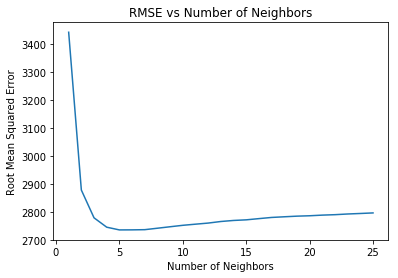

The minimum RMSE of a signle kNN's predictions of actual dollar amounts is $2736.732456


In [20]:
plt.plot(np.arange(1,26), knnr_loss_history);
plt.xlabel("Number of Neighbors");
plt.ylabel("Root Mean Squared Error");
plt.title("RMSE vs Number of Neighbors");
plt.show(); #use 5 neighbors for minimum RMSE  
print("The minimum RMSE of a signle kNN's predictions of actual dollar amounts is $%f" % min(knnr_loss_history)); 

KNN performs best on the validation set when using the 5 nearest neighbors to predict losses. Since our KNN algorithm is only being trained on 100 rows out of the entire dataset, we'll use an ensemble of 20 different KNN models, each trained on a different 100-row subset of the dataset, with only 5 variables being used in each one of the 20 different KNN models. We'll then average the predictions of each of our 20 different KNN models to get our final answer. 

In [21]:
knnr = BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=5, weights="distance"),
                        n_estimators=20,
                        max_samples=100,
                        max_features=5,
                        bootstrap=False,
                        random_state=42)
knnr = knnr.fit(train_x, train_y.values.ravel())
valid_pred_knnr = pd.DataFrame(knnr.predict(valid_x), columns = ['predknnr'])
valid_pred_knnr = np.exp(loss_scaler.inverse_transform(valid_pred_knnr))    
mse_knnr = mean_squared_error(valid_y_actual, valid_pred_knnr) ** 0.5
mae_knnr = mean_absolute_error(valid_y_actual, valid_pred_knnr)
print("The minimum RMSE of 20 kNN predictions(ensemble) of actual dollar amounts is $%f" % mse_knnr)
print("Mean absolute error of 20 kNN predictions(ensemble) of actual dollar amounts is $%f" % mae_knnr)

The minimum RMSE of 20 kNN predictions(ensemble) of actual dollar amounts is $2679.506244
Mean absolute error of 20 kNN predictions(ensemble) of actual dollar amounts is $1605.969715


We can see that the ensemble's RMSE (2679.50) is lower than a single KNN model's RMSE (2736.73). Let's see if we can build other base models to assemble the base learners for our ensemble at the end. Since stacking/blending models tends to work best if we use a diverse set of base learners to cover each others' weaknesses, we'll start with several versions of decision tree models. 

We'll try a random forest, an ensemble of many different decision trees trained on different subsets of all of the predictive variables, and then the results from the different trees is averaged together to form a final answer.

Then we'll use a gradient boosted decision tree, where one tree is initially built, then another tree is built to estimate how far off the previous tree is from the actual answer, and then yet another tree is built to estimate how far off the previous two trees added together are from the actual answer. This continues until an arbitrary stopping point. 

For the final tree based model, we'll use an adaboosted (ADAptive BOOSTing) forest. Like a random forest, it's an an ensemble of many different decision trees trained on different subsets of all of the predictive variables, and then the results from the different trees is averaged together to form a final answer. However, for subsequent trees, data points which previous trees had higher prediction error on will have higher weights, so the subsequent trees will focus on reducing the prediction error on those data points more than the ones previous trees were good at predicting. In other words, subsequent decision trees will focus on data points it had trouble predicting previously.  

In [22]:
random_forest = RandomForestRegressor(n_estimators=50,
                                      max_depth=20,
                                      max_features=30,
                                      min_samples_split = 25,
                                      bootstrap=False,
                                      random_state=42)
random_forest = random_forest.fit(train_x, train_y.values.ravel())
valid_pred_rf = pd.DataFrame(random_forest.predict(valid_x), columns = ['predrf'])
valid_pred_rf = np.exp(loss_scaler.inverse_transform(valid_pred_rf))    
mse_rf = mean_squared_error(valid_y_actual, valid_pred_rf) ** 0.5
mae_rf = mean_absolute_error(valid_y_actual, valid_pred_rf)
print("The RMSE of random forest predictions of actual dollar amounts is $%f" % mse_rf)
print("Mean absolute error of random forest predictions of actual dollar amounts is $%f" % mae_rf)

The RMSE of random forest predictions of actual dollar amounts is $2016.605967
Mean absolute error of random forest predictions of actual dollar amounts is $1203.483264


In [23]:
gb_forest = GradientBoostingRegressor(max_depth=7,
                                      n_estimators=250,
                                      random_state=42)
gb_forest = gb_forest.fit(train_x, train_y.values.ravel())
valid_pred_gb = pd.DataFrame(gb_forest.predict(valid_x), columns = ['predgb'])
valid_pred_gb = np.exp(loss_scaler.inverse_transform(valid_pred_gb))    
mse_gb = mean_squared_error(valid_y_actual, valid_pred_gb) ** 0.5
mae_gb = mean_absolute_error(valid_y_actual, valid_pred_gb)
print("The RMSE of gradient boosted forest predictions of actual dollar amounts is $%f" % mse_gb)
print("Mean absolute error of gradient boosted forest predictions of actual dollar amounts is $%f" % mae_gb)

The RMSE of gradient boosted forest predictions of actual dollar amounts is $1932.767157
Mean absolute error of gradient boosted forest predictions of actual dollar amounts is $1165.534416


In [24]:
ada_forest = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=25,
                                                                    max_features=50,
                                                                    min_samples_split = 25),
                                                                    random_state=42,
                                                                    loss="square",
                                                                    n_estimators=250)
ada_forest = ada_forest.fit(train_x, train_y.values.ravel())
valid_pred_ada = pd.DataFrame(ada_forest.predict(valid_x), columns = ['predada'])
valid_pred_ada = np.exp(loss_scaler.inverse_transform(valid_pred_ada))
mse_ada = mean_squared_error(valid_y_actual, valid_pred_ada) ** 0.5
mae_ada = mean_absolute_error(valid_y_actual, valid_pred_ada)
print("The RMSE of adaboosted forest predictions of actual dollar amounts is $%f" % mse_ada)
print("Mean absolute error of adaboosted boosted forest predictions of actual dollar amounts is $%f" % mae_ada)

The RMSE of adaboosted forest predictions of actual dollar amounts is $1985.039509
Mean absolute error of adaboosted boosted forest predictions of actual dollar amounts is $1200.092232


Next, we'll move onto the support vector machine models. We'll use a linear support vector regression model, and a kernel-based support vector regression model.

In [25]:
linsvr = LinearSVR()
linsvr = linsvr.fit(train_x, train_y.values.ravel())
valid_pred_linsvr = pd.DataFrame(linsvr.predict(valid_x), columns = ['predlinsvr'])
valid_pred_linsvr = np.exp(loss_scaler.inverse_transform(valid_pred_linsvr))
mse_linsvr = mean_squared_error(valid_y_actual, valid_pred_linsvr) ** 0.5
mae_linsvr = mean_absolute_error(valid_y_actual, valid_pred_linsvr)
print("The RMSE of linear SVR predictions of actual dollar amounts is $%f" % mse_linsvr)
print("Mean absolute error of linear SVR predictions of actual dollar amounts is $%f" % mae_linsvr)

The RMSE of linear SVR predictions of actual dollar amounts is $2173.881400
Mean absolute error of linear SVR predictions of actual dollar amounts is $1278.666285


In [26]:
kernelsvr = BaggingRegressor(base_estimator=SVR(),
                             n_estimators=2,
                             max_samples=2500,
                             bootstrap=False,
                             random_state=42)
kernelsvr = kernelsvr.fit(train_x, train_y.values.ravel())
valid_pred_kernelsvr = pd.DataFrame(kernelsvr.predict(valid_x), columns = ['predkernelsvr'])
valid_pred_kernelsvr = np.exp(loss_scaler.inverse_transform(valid_pred_kernelsvr))
mse_kernelsvr = mean_squared_error(valid_y_actual, valid_pred_kernelsvr) ** 0.5
mae_kernelsvr = mean_absolute_error(valid_y_actual, valid_pred_kernelsvr)
print("The RMSE of Kernel SVR predictions of actual dollar amounts is $%f" % mse_kernelsvr)
print("Mean absolute error of Kernel SVR predictions of actual dollar amounts is $%f" % mae_kernelsvr)

The RMSE of Kernel SVR predictions of actual dollar amounts is $2051.062195
Mean absolute error of Kernel SVR predictions of actual dollar amounts is $1240.834414


Finally, we'll model losses using more traditional linear regression methods. We'll use a simple linear regression, a linear regression with L1 regularization (lasso), and a linear regression with L2 regularization (ridge). 

In [27]:
lm = LinearRegression().fit(train_x, train_y.values.ravel())
valid_pred_lm = pd.DataFrame(lm.predict(valid_x), columns = ['predlm'])
valid_pred_lm = np.exp(loss_scaler.inverse_transform(valid_pred_lm))
mse_lm = mean_squared_error(valid_y_actual, valid_pred_lm) ** 0.5
mae_lm = mean_absolute_error(valid_y_actual, valid_pred_lm)
print("The RMSE of linear regression predictions of actual dollar amounts is $%f" % mse_lm)
print("Mean absolute error of linear regression predictions of actual dollar amounts is $%f" % mae_lm)

The RMSE of linear regression predictions of actual dollar amounts is $2147.487458
Mean absolute error of linear regression predictions of actual dollar amounts is $1271.485751


In [28]:
lasso = Lasso(alpha=0.001, max_iter=10000).fit(train_x, train_y.values.ravel())
valid_pred_lasso = pd.DataFrame(lasso.predict(valid_x), columns = ['predlasso'])
valid_pred_lasso = np.exp(loss_scaler.inverse_transform(valid_pred_lasso))
mse_lasso = mean_squared_error(valid_y_actual, valid_pred_lasso) ** 0.5
mae_lasso = mean_absolute_error(valid_y_actual, valid_pred_lasso)
print("The RMSE of lasso regression predictions of actual dollar amounts is $%f" % mse_lasso)
print("Mean absolute error of lasso regression predictions of actual dollar amounts is $%f" % mae_lasso)

The RMSE of lasso regression predictions of actual dollar amounts is $2129.560862
Mean absolute error of lasso regression predictions of actual dollar amounts is $1268.937087


In [29]:
ridge = Ridge(alpha=890, max_iter=10000).fit(train_x, train_y.values.ravel())
valid_pred_ridge = pd.DataFrame(ridge.predict(valid_x), columns = ['predridge'])
valid_pred_ridge = np.exp(loss_scaler.inverse_transform(valid_pred_ridge))
mse_ridge = mean_squared_error(valid_y_actual, valid_pred_ridge) ** 0.5
mae_ridge = mean_absolute_error(valid_y_actual, valid_pred_ridge)
print("The RMSE of ridge regression predictions of actual dollar amounts is $%f" % mse_ridge)
print("Mean absolute error of ridge regression predictions of actual dollar amounts is $%f" % mae_ridge)

The RMSE of ridge regression predictions of actual dollar amounts is $2125.364547
Mean absolute error of ridge regression predictions of actual dollar amounts is $1268.364667


We'll output the predictions of each algorithm on the training and validation dataset.

In [30]:
train_pred = pd.DataFrame(train_pred_nn, columns = ['prednn'])
train_pred["predknnr"] = knnr.predict(train_x)
train_pred["predrf"] = random_forest.predict(train_x)
train_pred["predgb"] = gb_forest.predict(train_x) 
train_pred["predada"] = ada_forest.predict(train_x)
train_pred["predlinsvr"] = linsvr.predict(train_x)
train_pred["predkernelsvr"] = kernelsvr.predict(train_x)
train_pred["predlm"] = lm.predict(train_x)
train_pred["predlasso"] = lasso.predict(train_x)
train_pred["predridge"] = ridge.predict(train_x)
# train_x1 = train_x.reset_index(drop=True)
# train_pred = pd.concat([train_x1, train_pred], axis = 1)
train_pred.head()

,prednn,predknnr,predrf,predgb,predada,predlinsvr,predkernelsvr,predlm,predlasso,predridge
0,0.83427,0.39623,0.57545,0.75952,0.57676,0.88589,0.87775,0.85659,0.86376,0.85408
1,-0.80258,-0.13721,-0.69249,-0.71702,-0.63517,-0.71865,-0.76149,-0.72648,-0.70856,-0.70821
2,0.93078,0.44686,0.92974,0.77150,1.14541,0.53395,0.68409,0.52357,0.56144,0.54094
3,-0.66196,-0.09743,-0.70450,-0.76806,-0.73684,-0.61726,-0.47046,-0.60229,-0.60048,-0.58048
4,1.28680,0.43323,1.15517,1.31773,1.02694,1.11821,0.82731,1.08415,0.99681,0.97610


In [31]:
valid_pred = pd.DataFrame(valid_pred_nn, columns = ['prednn'])
valid_pred["predknnr"] = knnr.predict(valid_x)
valid_pred["predrf"] = random_forest.predict(valid_x)
valid_pred["predgb"] = gb_forest.predict(valid_x) 
valid_pred["predada"] = ada_forest.predict(valid_x)
valid_pred["predlinsvr"] = linsvr.predict(valid_x)
valid_pred["predkernelsvr"] = kernelsvr.predict(valid_x)
valid_pred["predlm"] = lm.predict(valid_x)
valid_pred["predlasso"] = lasso.predict(valid_x)
valid_pred["predridge"] = ridge.predict(valid_x)
# valid_x1 = valid_x.reset_index(drop=True)
# valid_pred = pd.concat([valid_x1, valid_pred], axis = 1)
valid_pred.head()

,prednn,predknnr,predrf,predgb,predada,predlinsvr,predkernelsvr,predlm,predlasso,predridge
0,-0.33714,-0.10819,-0.28255,-0.09281,-0.39031,-0.40908,-0.59944,-0.39403,-0.37448,-0.37847
1,-0.32473,0.25033,-0.38262,-0.42636,-0.24626,-0.25530,-0.13582,-0.25625,-0.26172,-0.27025
2,0.52087,0.49711,0.44037,0.40274,0.39110,1.02348,0.94090,0.98810,1.00706,0.99388
3,1.45031,0.49674,1.00193,1.40733,1.16623,1.05396,0.99586,1.01399,0.83756,0.86252
4,-1.16255,-0.20217,-0.77686,-1.13512,-0.75944,-0.81082,-0.50727,-0.81861,-0.73452,-0.75403


Now we'll compare each model's performance in order to select a weight for each model. This will be used when compiling our final predictions, a weighted average of all the model's predictions. 

Models that have lower RMSEs will have higher weights. We'll compute model weights by dividing the highest RMSE by the individual model's RMSE. This will give the worst performing model a weight of 1, and the remaining, higher performing models a weight greater than 1. We'll raise each weight to the 60th power to weigh models with higher performance more heavily. 

In [32]:
mse = [mse_nn, mse_knnr, mse_rf, mse_gb, mse_ada, mse_linsvr, mse_kernelsvr, mse_lm, mse_lasso, mse_ridge]
mae = [mae_nn, mae_knnr, mae_rf, mae_gb, mae_ada, mae_linsvr, mae_kernelsvr, mae_lm, mae_lasso, mae_ridge]
model_types = ["Neural Network", "K-Nearest Neighbors", "Random Forest", "Gradient Boost",
               "AdaBoost", "Linear Support Vector Machine", "Kernel Support Vector Machine", 
               "Linear Regression", "Lasso Regression", "Ridge Regression"]
model_comparison = pd.DataFrame([model_types, mse, mae]).T
model_comparison.columns = ['Model Type', 'Root Mean Squared Error', 'Mean Absolute Error']
base_model = model_comparison['Root Mean Squared Error'].max()
model_comparison['Weight'] = (base_model/model_comparison['Root Mean Squared Error']) ** 60
normalizing_weight = model_comparison['Weight'].sum()
model_comparison
weighted_average = (valid_pred.mul(model_comparison['Weight'].tolist(), axis=1).sum(axis=1).tolist())/normalizing_weight
weighted_average = np.exp(loss_scaler.inverse_transform(weighted_average))
mse_avg = mean_squared_error(valid_y_actual, weighted_average) ** 0.5
mae_avg = mean_absolute_error(valid_y_actual, weighted_average)
print("The RMSE of weighed average predictions of actual dollar amounts is $%f" % mse_avg)
print("Mean absolute error of weighed average predictions of actual dollar amounts is $%f" % mae_avg)

,Model Type,Root Mean Squared Error,Mean Absolute Error,Weight
0,Neural Network,1907.95961,1159.16124,706538548.86639
1,K-Nearest Neighbors,2679.50624,1605.96972,1.00000
2,Random Forest,2016.60597,1203.48326,25469682.73987
3,Gradient Boost,1932.76716,1165.53442,325472413.57638
4,AdaBoost,1985.03951,1200.09223,65635243.05107
5,Linear Support Vector Machine,2173.88140,1278.66628,281277.89668
6,Kernel Support Vector Machine,2051.06220,1240.83441,9216300.24575
7,Linear Regression,2147.48746,1271.48575,585393.96807
8,Lasso Regression,2129.56086,1268.93709,968017.05866
9,Ridge Regression,2125.36455,1268.36467,1089633.62351


The RMSE of weighed average predictions of actual dollar amounts is $1903.283115
Mean absolute error of weighed average predictions of actual dollar amounts is $1150.294477


Let's run our ensemble model on the testing dataset and see how well it performs, along with our base neural network and gradient boosted tree, to see if the base models themselves perform well enough by themselves. 

In [33]:
test_pred = pd.DataFrame(test_pred_nn, columns = ['prednn'])
test_pred["predknnr"] = knnr.predict(test_x)
test_pred["predrf"] = random_forest.predict(test_x)
test_pred["predgb"] = gb_forest.predict(test_x) 
test_pred["predada"] = ada_forest.predict(test_x)
test_pred["predlinsvr"] = linsvr.predict(test_x)
test_pred["predkernelsvr"] = kernelsvr.predict(test_x)
test_pred["predlm"] = lm.predict(test_x)
test_pred["predlasso"] = lasso.predict(test_x)
test_pred["predridge"] = ridge.predict(test_x)

In [34]:
weighted_average = (test_pred.mul(model_comparison['Weight'].tolist(), axis=1).sum(axis=1).tolist())/normalizing_weight
weighted_average = np.exp(loss_scaler.inverse_transform(weighted_average))
mse_avg = mean_squared_error(test_y_actual, weighted_average) ** 0.5
mae_avg = mean_absolute_error(test_y_actual, weighted_average)
print("The RMSE of weighed average predictions of actual dollar amounts is $%f" % mse_avg)
print("Mean absolute error of weighed average predictions of actual dollar amounts is $%f" % mae_avg)

The RMSE of weighed average predictions of actual dollar amounts is $2016.291651
Mean absolute error of weighed average predictions of actual dollar amounts is $1179.845037


In [35]:
test_nn_unscaled = np.exp(loss_scaler.inverse_transform(test_pred_nn))
mse_nn = mean_squared_error(test_y_actual, test_nn_unscaled) ** 0.5
mae_nn = mean_absolute_error(test_y_actual, test_nn_unscaled)
print("Root mean squared error of neural network predictions of actual dollar amounts is $%f" % mse_nn) 
print("Mean absolute error of neural network predictions of actual dollar amounts is $%f" % mae_nn)

Root mean squared error of neural network predictions of actual dollar amounts is $2036.090920
Mean absolute error of neural network predictions of actual dollar amounts is $1191.061486


In [36]:
test_pred_gb = pd.DataFrame(gb_forest.predict(test_x), columns = ['predgb'])
test_pred_gb = np.exp(loss_scaler.inverse_transform(test_pred_gb))    
mse_gb = mean_squared_error(test_y_actual, test_pred_gb) ** 0.5
mae_gb = mean_absolute_error(test_y_actual, test_pred_gb)
print("The RMSE of gradient boosted forest predictions of actual dollar amounts is $%f" % mse_gb)
print("Mean absolute error of gradient boosted forest predictions of actual dollar amounts is $%f" % mae_gb)

The RMSE of gradient boosted forest predictions of actual dollar amounts is $2175.142870
Mean absolute error of gradient boosted forest predictions of actual dollar amounts is $1192.369704


It appears that the weighted average outperforms the top two base models, and it has not overfit the training/validation set. 

# Further work

There is still plenty more to work on. Perhaps instead of throwing out categorical variables whose least common category occurs less than 0.25% of the time, they could be left in with some alternate way to process them. Maybe convert the categorical variable into a continuous variable by using impact coding, to reduce dimensionality and the effect of high cardinality. 

We could have also used another neural network as the final stacked model sitting on top of all of the base learners, instead of taking a simple weighted average of all the base learners. 